In [1]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

/cerebralcortex/kessel_jupyter_virtualenv/tensorflow/lib/python3.7/site-packages/pandas-1.2.3-py3.7-linux-x86_64.egg/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import tensorflow as tf
import os
import pickle
import pandas as pd
import numpy as np

def get_testing_data(directory,min_length,window_size):
    X = []
    y = []
    n = 60//window_size
    for f in os.listdir(directory):
        if f[0]=='.':
            continue
        data = pickle.load(open(directory+f,'rb'))
        if data.shape[0]//n<min_length:
            continue
        X.append(np.concatenate(list(data['data'])))
        y.extend([f]*data.shape[0])
    return np.concatenate(X),np.array(y)

window_size = 20
activity = 'stationery'
n_user  = 332
min_length = 1000
data_directory = './data/'+str(window_size)+'/'+activity+'/testing/'
model_directory = './models/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
train_lengths = os.listdir(model_directory)
X,y = get_testing_data(data_directory,min_length,window_size)
save_directory = './predictions/'+str(window_size)+'/'+activity+'/'+str(n_user)+'/'
result_directory = './results/'
if not os.path.isdir(save_directory):
    os.makedirs(save_directory)

In [3]:
X.shape,y.shape

((996000, 500, 3), (996000,))

In [4]:
train_length = 500

In [5]:
model_files = [model_directory+str(train_length)+'/'+a for a in os.listdir(model_directory+str(train_length)) if a[-1]=='5']

In [6]:
model_name = model_files[0]

In [7]:
model = tf.keras.models.load_model(model_name)

In [8]:
model_new = tf.keras.models.Model(model.input,model.layers[-2].output)

In [9]:
y_pred = model_new.predict(X)

In [10]:
from copy import deepcopy
features = deepcopy(y_pred)

In [11]:
features.shape

(996000, 332)

In [12]:
from sklearn.decomposition import TruncatedSVD,PCA

In [13]:
features = PCA(n_components=100).fit_transform(features)

In [14]:
d = features.shape[1]
np.linalg.det(np.cov(features[:,:d].T))

2.2504755150574813e+17

In [15]:
d = features.shape[1]
entropy = .5*np.log(np.linalg.det(np.cov(features[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
entropy

161.871397377873

In [16]:
unique_users = np.unique(y)

In [17]:
len(unique_users)

332

In [18]:
user_df =pd.DataFrame({'user':np.unique(y)})
index_df = pd.DataFrame({'user':y,'index':np.arange(len(y))})
n_users = np.arange(1,10,1)
n_iter = 10

def get_average_entropy(n_user,n_iter):
    result = []
    for k in range(n_iter):
        temp_users = np.unique(user_df.sample(n_user,replace=False)['user'].values)
        index = index_df[index_df.user.isin(temp_users)]['index'].values
        temp_feature = features[index]
        d  = temp_feature.shape[1]
        entropy = .5*np.log(np.linalg.det(np.cov(temp_feature[:,:d].T))) + (d/2)*(1+np.log(2*np.pi))
        result.append(entropy)
    return np.array([n_user,np.mean(result)])
from joblib import Parallel,delayed
result = []
for i in range(1,295,20):
    entropies = Parallel(n_jobs=20,verbose=2)(delayed(get_average_entropy)(n_user,n_iter) for i,n_user in enumerate(range(i,i+20)))
    print(entropies)
    result.extend(entropies)
    pickle.dump(result,open('./data/entropies_'+str(activity)+'.p','wb'))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   12.9s remaining:  1.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   18.9s remaining:    8.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   22.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 1.        , 92.70964867]), array([  2.        , 101.91478174]), array([  3.        , 117.49336776]), array([  4.        , 128.58629486]), array([  5.        , 129.19294225]), array([  6.        , 132.76974638]), array([  7.        , 135.26565492]), array([  8.        , 139.55907799]), array([  9.        , 137.18509747]), array([ 10.        , 139.88526175]), array([ 11.        , 141.85449501]), array([ 12.        , 142.38662206]), array([ 13.        , 145.06632705]), array([ 14.       , 144.7711616]), array([ 15.        , 143.83538332]), array([ 16.        , 145.58224294]), array([ 17.        , 147.07863908]), array([ 18.        , 145.57389456]), array([ 19.        , 148.22279799]), array([ 20.        , 148.53838198])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    4.9s remaining:   27.7s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   11.3s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   14.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 21.        , 148.88310977]), array([ 22.        , 150.44816821]), array([ 23.        , 150.50871903]), array([ 24.        , 151.67695284]), array([ 25.        , 150.28404225]), array([ 26.       , 150.0952556]), array([ 27.        , 153.11008072]), array([ 28.        , 152.05507522]), array([ 29.        , 152.51070536]), array([ 30.        , 153.32443051]), array([ 31.        , 153.60717734]), array([ 32.        , 152.39857608]), array([ 33.        , 155.48088373]), array([ 34.       , 152.0075808]), array([ 35.        , 153.75873454]), array([ 36.        , 155.12568624]), array([ 37.        , 153.93655997]), array([ 38.        , 153.20273787]), array([ 39.       , 155.5323938]), array([ 40.        , 154.98336092])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    6.3s remaining:   35.5s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   13.0s remaining:    5.6s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   16.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 41.        , 154.93217041]), array([ 42.        , 154.71484715]), array([ 43.        , 155.75747114]), array([ 44.        , 154.26635675]), array([ 45.        , 156.57135417]), array([ 46.        , 155.77290107]), array([ 47.        , 155.91604164]), array([ 48.        , 156.13858729]), array([ 49.       , 156.8540735]), array([ 50.        , 155.42068359]), array([ 51.        , 155.96472616]), array([ 52.        , 156.90032409]), array([ 53.        , 156.58887277]), array([ 54.        , 157.46306795]), array([ 55.        , 156.11246793]), array([ 56.        , 154.55305321]), array([ 57.        , 155.72889239]), array([ 58.        , 157.93452314]), array([ 59.        , 156.97361596]), array([ 60.        , 157.21155156])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    7.5s remaining:   42.4s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   14.1s remaining:    6.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   17.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 61.        , 157.57064038]), array([ 62.        , 157.60163651]), array([ 63.        , 157.42130344]), array([ 64.        , 157.44336077]), array([ 65.       , 156.2213876]), array([ 66.        , 157.38091449]), array([ 67.        , 157.17177472]), array([ 68.        , 157.03556117]), array([ 69.        , 157.56295212]), array([ 70.        , 158.29877971]), array([ 71.        , 157.89571365]), array([ 72.        , 157.77873577]), array([ 73.        , 157.78216992]), array([ 74.        , 157.40277952]), array([ 75.        , 157.83475826]), array([ 76.        , 159.77995862]), array([ 77.        , 157.85931032]), array([ 78.        , 159.24528101]), array([ 79.        , 159.17930495]), array([ 80.        , 157.68840474])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    9.0s remaining:   50.9s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   16.4s remaining:    7.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   20.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([ 81.        , 158.66711571]), array([ 82.        , 158.36487328]), array([ 83.        , 157.05650402]), array([ 84.        , 158.85698847]), array([ 85.        , 159.46232258]), array([ 86.        , 158.16405498]), array([ 87.        , 159.21534259]), array([ 88.        , 158.78439318]), array([ 89.        , 157.55147505]), array([ 90.        , 159.20961879]), array([ 91.        , 159.73286073]), array([ 92.        , 159.28873796]), array([ 93.        , 158.37489145]), array([ 94.        , 158.23640671]), array([ 95.       , 159.7609859]), array([ 96.        , 159.21182089]), array([ 97.        , 159.06356165]), array([ 98.        , 159.24440292]), array([ 99.        , 158.57664675]), array([100.        , 158.64040529])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   10.5s remaining:   59.4s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   18.5s remaining:    7.9s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   23.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([101.        , 158.70741521]), array([102.        , 158.79513848]), array([103.        , 159.02670884]), array([104.        , 158.97641789]), array([105.        , 159.70659708]), array([106.        , 159.19533183]), array([107.        , 159.27432518]), array([108.        , 158.66246093]), array([109.       , 159.5793059]), array([110.        , 160.00999596]), array([111.       , 159.9369756]), array([112.        , 159.94011414]), array([113.        , 159.27131025]), array([114.        , 159.01915615]), array([115.        , 159.00561637]), array([116.        , 159.46244681]), array([117.        , 159.23806868]), array([118.        , 159.58107049]), array([119.        , 159.86870731]), array([120.        , 160.47851351])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   12.5s remaining:  1.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   20.4s remaining:    8.8s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   24.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([121.        , 159.96743068]), array([122.       , 160.3033213]), array([123.        , 159.53473832]), array([124.        , 160.27672149]), array([125.        , 159.75163568]), array([126.        , 160.53212316]), array([127.        , 160.11757218]), array([128.        , 160.29277756]), array([129.        , 160.38055735]), array([130.        , 160.22093364]), array([131.        , 159.60854366]), array([132.       , 160.0965115]), array([133.        , 160.55896779]), array([134.        , 160.00288715]), array([135.        , 160.03427893]), array([136.        , 160.19472111]), array([137.        , 160.68888678]), array([138.        , 160.37134924]), array([139.        , 160.03711165]), array([140.        , 160.31310697])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   14.8s remaining:  1.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   22.0s remaining:    9.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   27.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([141.        , 160.78564456]), array([142.        , 160.03322695]), array([143.        , 160.39181418]), array([144.        , 159.90662691]), array([145.        , 161.55872536]), array([146.        , 159.50628383]), array([147.        , 160.55375594]), array([148.        , 160.31346133]), array([149.        , 160.60205116]), array([150.        , 160.07260336]), array([151.        , 160.67434366]), array([152.        , 159.68146743]), array([153.        , 159.91188381]), array([154.        , 160.13805494]), array([155.        , 160.36478345]), array([156.        , 161.04842553]), array([157.        , 160.64828625]), array([158.        , 160.91343017]), array([159.        , 160.57542441]), array([160.        , 160.51381405])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   16.7s remaining:  1.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   23.3s remaining:   10.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   28.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([161.        , 160.54417951]), array([162.       , 160.4229949]), array([163.        , 160.39389306]), array([164.        , 160.45583795]), array([165.       , 160.7806996]), array([166.        , 160.72270664]), array([167.        , 160.36629548]), array([168.        , 160.85210619]), array([169.        , 160.51569548]), array([170.        , 160.72525476]), array([171.        , 160.82919331]), array([172.        , 160.82480238]), array([173.        , 161.12211374]), array([174.        , 161.05831545]), array([175.        , 160.59982069]), array([176.        , 161.11363109]), array([177.        , 160.61593714]), array([178.        , 160.70619437]), array([179.        , 161.03794685]), array([180.        , 160.84048163])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   17.1s remaining:  1.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   25.9s remaining:   11.1s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   30.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([181.        , 160.61571127]), array([182.        , 161.07267704]), array([183.        , 160.57143403]), array([184.       , 160.9804284]), array([185.        , 160.95189643]), array([186.        , 161.11715559]), array([187.        , 160.91324485]), array([188.        , 160.83192123]), array([189.        , 160.89380998]), array([190.        , 161.36724584]), array([191.        , 160.94964941]), array([192.        , 161.10842422]), array([193.        , 160.33978696]), array([194.        , 161.22886785]), array([195.        , 161.11752283]), array([196.        , 161.07019592]), array([197.       , 161.4682447]), array([198.        , 160.75987758]), array([199.        , 161.15557843]), array([200.        , 160.91832955])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   18.9s remaining:  1.8min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   26.8s remaining:   11.5s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   32.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([201.       , 160.8693242]), array([202.        , 161.00377688]), array([203.        , 160.79563928]), array([204.        , 161.47700559]), array([205.        , 161.47141187]), array([206.        , 161.19127652]), array([207.        , 161.03690455]), array([208.        , 161.04886143]), array([209.        , 161.24611534]), array([210.        , 161.07707946]), array([211.        , 161.47562255]), array([212.       , 161.0860498]), array([213.        , 161.28111843]), array([214.        , 161.01599156]), array([215.       , 161.4618388]), array([216.        , 160.87515352]), array([217.        , 161.20465752]), array([218.       , 161.3272615]), array([219.        , 161.06115967]), array([220.        , 161.18372934])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   20.5s remaining:  1.9min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   29.2s remaining:   12.5s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   34.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([221.        , 161.41284562]), array([222.        , 161.31829517]), array([223.        , 161.04478032]), array([224.        , 161.31265888]), array([225.        , 161.48182408]), array([226.        , 161.27008324]), array([227.        , 161.45266759]), array([228.        , 161.22628036]), array([229.        , 161.62880762]), array([230.        , 161.23922836]), array([231.        , 161.20961642]), array([232.        , 161.19868003]), array([233.        , 161.54871385]), array([234.        , 161.37211948]), array([235.        , 161.45229615]), array([236.        , 161.59678656]), array([237.       , 161.2726036]), array([238.        , 160.94679964]), array([239.        , 161.38145478]), array([240.        , 161.59956347])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   23.0s remaining:  2.2min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   31.1s remaining:   13.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   36.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([241.       , 161.3449983]), array([242.        , 161.51134522]), array([243.        , 161.11827325]), array([244.        , 161.33478364]), array([245.        , 161.18017013]), array([246.     , 161.21958]), array([247.        , 161.18630513]), array([248.        , 161.08861463]), array([249.        , 160.90226728]), array([250.        , 161.04322841]), array([251.       , 161.4336263]), array([252.        , 161.22650022]), array([253.        , 161.41452466]), array([254.        , 161.72722539]), array([255.        , 161.52247318]), array([256.        , 161.41628453]), array([257.        , 161.27679146]), array([258.        , 161.34653045]), array([259.        , 161.50744737]), array([260.        , 161.68586029])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   25.3s remaining:  2.4min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   33.6s remaining:   14.4s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   39.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[array([261.        , 161.73340462]), array([262.       , 161.3627468]), array([263.        , 161.48631415]), array([264.        , 161.71212785]), array([265.       , 161.6140527]), array([266.        , 161.71805751]), array([267.        , 161.19836321]), array([268.        , 161.85796922]), array([269.        , 161.48092529]), array([270.        , 161.59718331]), array([271.        , 161.34228696]), array([272.       , 161.6295398]), array([273.        , 161.62014224]), array([274.        , 161.46989561]), array([275.       , 161.4316927]), array([276.        , 161.64516828]), array([277.        , 161.54081315]), array([278.        , 161.56873129]), array([279.        , 161.61106964]), array([280.        , 161.75755493])]


[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   27.0s remaining:  2.6min
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:   34.3s remaining:   14.7s


[array([281.        , 161.51083049]), array([282.        , 161.55120374]), array([283.        , 161.58970876]), array([284.        , 161.65575576]), array([285.        , 161.64025565]), array([286.        , 161.36668214]), array([287.       , 161.6398953]), array([288.        , 161.86249024]), array([289.        , 161.52500603]), array([290.        , 161.56700865]), array([291.        , 161.73520941]), array([292.        , 161.71462302]), array([293.        , 161.40028952]), array([294.        , 161.36923125]), array([295.        , 161.69112804]), array([296.        , 161.51241348]), array([297.        , 161.69543127]), array([298.        , 161.83903587]), array([299.        , 161.78872587]), array([300.        , 161.67048955])]


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   43.4s finished


In [210]:
activity = 'sports'
result = pickle.load(open('./data/entropies_'+str(activity)+'.p','rb'))

In [19]:
activities = ['sports','walking','std','std15','std30','std25','stairs']
activities = ['stationery']

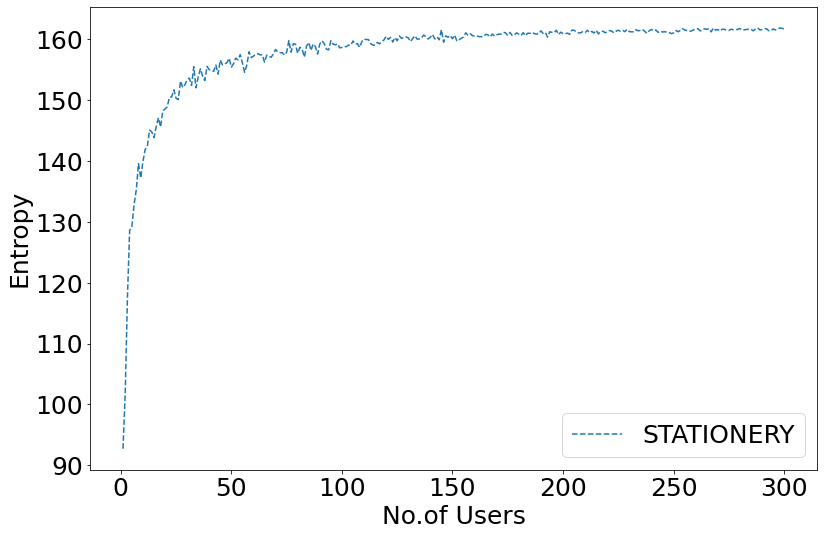

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(12,8))
for i,activity in enumerate(activities):
    result = pickle.load(open('./data/entropies_'+str(activity)+'.p','rb'))
    result = np.array(result)
    result = result[result[:,0]<=300]
    if activity[:3]!='std':
        plt.plot(result[:,0],result[:,1],'--',label=activity.upper())
    elif activity=='std':
        plt.plot(result[:,0],result[:,1],'--',label=activity.upper()+' >= ''.2')
    else:
        plt.plot(result[:,0],result[:,1],'--',label=activity[:3].upper()+' >= '+str(int(activity[3:])/100))
plt.ylabel('Entropy')
plt.xlabel('No.of Users')
plt.legend()
plt.tight_layout()
plt.savefig('./images/entropy.png')
plt.show()

In [191]:
result = np.array(result)

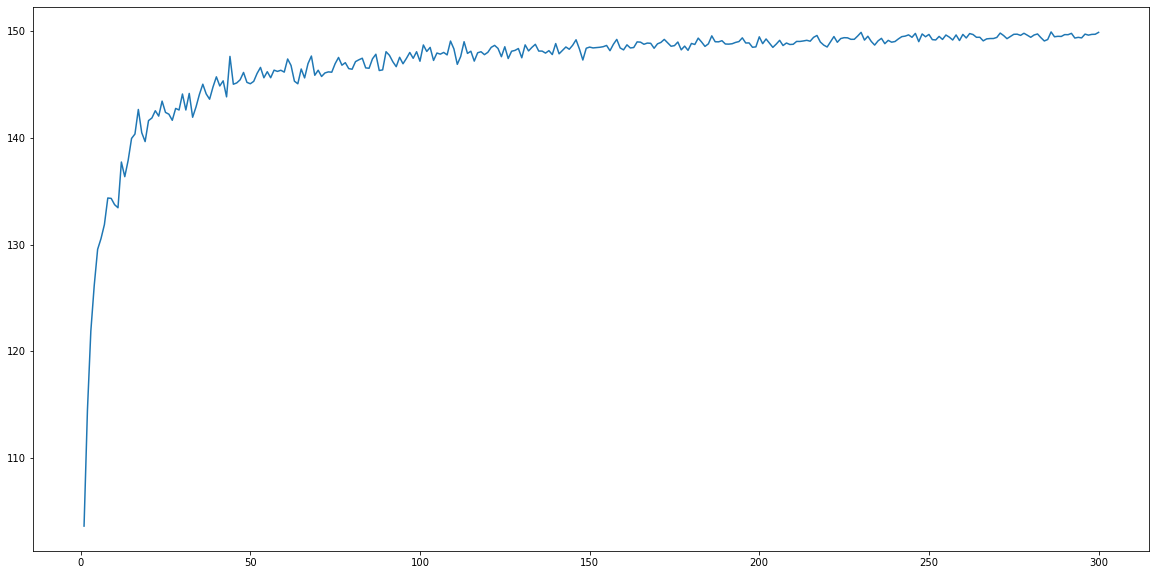

In [192]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(result[:,0],result[:,1])
plt.show()

In [196]:
activities = ['walking','sports','std']

In [197]:
for activity in activities[::-1]:
    result = np.array(pickle.load(open('./data/entropies_'+str(activity)+'.p')))
    print(result)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte